# 3b + not loose

**Goal:** For ggF, we introduced $\Delta \eta_{hh}$ cats, so now we're investigating opportunities to *validate* this.

I put back in some functionality that Sean had before... so I think it's just good to start *sanity checking* some of the rw plots now haha :-)

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import product
from glob import glob
import uproot
import matplotlib.pyplot as plt
from matplotlib import gridspec

import os
os.sys.path+= ['../RRevolution/code/','../PAG-opt/','../code/']
from analysis import getXhh
from utils import mcToYr, L

from statUtils import calc_bstrap

from eventDisplays import rainbow_text

from plots import draw_SR, draw_VR, draw_CR
from rwPlots import *

import logging
for name in logging.Logger.manager.loggerDict.keys():
    logging.getLogger(name).setLevel(logging.CRITICAL)

# Let's do ATLAS style plots too!
import matplotlib as mpl
os.sys.path.append( "../PyATLASstyle/")
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

%load_ext autoreload
%autoreload 2

../PyATLASstyle/PyATLASstyle.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


**Step 1:** Load in the data

In [2]:
yr=16
bCat = '3b1nl'

fDir = '../data/RR/nr_bkts/isoMuon/'
fname = f'{fDir}/data{yr}_sr_124_117.root'
wname = f'{fDir}/data{yr}_sr_124_117_NN_100_bootstraps_{bCat}.root'

In [3]:
%%bash
ls ../data/RR/nr_bkts/isoMuon/

data16_sr_124_117_NN_100_bootstraps_3b1l.root
data16_sr_124_117_NN_100_bootstraps_3b1nl.root
data16_sr_124_117_NN_100_bootstraps_4b.root
data16_sr_124_117.root
data17_sr_124_117_NN_100_bootstraps_3b1l.root
data17_sr_124_117_NN_100_bootstraps_3b1nl.root
data17_sr_124_117_NN_100_bootstraps_4b.root
data17_sr_124_117.root
data18_sr_124_117.root


In [4]:
rw_cols = ['njets','pT_4','pT_2','dRjj_1','dRjj_2','eta_i','pt_hh','X_wt_tag','m_hh',
           'HT', 'dPhi_h1', 'dPhi_h2', 'dRjj_h1', 'dRjj_h2','dR_hh']

load_cols = ['event_number','run_number','dEta_hh','m_h1','m_h2','phi_h1','phi_h2','pass_vbf_sel'] 
load_cols += [f'{v}_h{i}_j{j}' for v,i,j in product(['pT','eta','phi','quantile'],[1,2],[1,2])]

wcols = ['event_number','run_number',
         f'NN_d24_weight_bstrap_med_{yr}', f'NN_d24_weight_VRderiv_bstrap_med_{yr}',
         f'NN_d24_weight_bstrap_IQR_{yr}', f'NN_d24_weight_VRderiv_bstrap_IQR_{yr}',
         f'rw_to_{bCat}',f'rw_to_{bCat}_VR']

cols = ['ntag'] + rw_cols[:9] + load_cols  

`About to calculate med norm on target 3b1nl
Nom med norm: 1.0288327358165361 Perc 25: 0.9703446054000445 Perc 75: 0.999937648368371 Norms IQR: 0.029593042968326433
VR med norm: 1.0416173539632951 Perc 25: 0.9736099970386678 Perc 75: 0.9937653373494941 Norms IQR: 0.02015534031082633`

In [5]:
with uproot.open(fname) as f:

    # uproot4 syntax
    sr = f['sig'].arrays(cols,library='pd')

with uproot.open(wname) as wf:
    
    for k in wf.keys():
        print(k)
    
    w_sr = wf['sig'].arrays(wcols,library='pd')
    
    norm     = wf[f'NN_norm_bstrap_med_{yr}'].all_members['fVal']
    norm_VR  = wf[f'NN_norm_VRderiv_bstrap_med_{yr}'].all_members['fVal']
    
    norm_IQR = wf[f'NN_norm_bstrap_IQR_{yr}'].all_members['fVal']
    norm_VR_IQR = wf[f'NN_norm_VRderiv_bstrap_IQR_{yr}'].all_members['fVal']
    
    kwargs = {'how':'left','on':["event_number","run_number"],'validate':"one_to_one"}
    sr = pd.merge(sr[~sr.pass_vbf_sel], w_sr, **kwargs)


control;1
validation;1
sig;1
NN_norm_bstrap_med_16;1
NN_norm_bstrap_IQR_16;1
NN_norm_bstrap_perc_25_16;1
NN_norm_bstrap_perc_75_16;1
NN_norm_VRderiv_bstrap_med_16;1
NN_norm_VRderiv_bstrap_IQR_16;1
NN_norm_VRderiv_bstrap_perc_25_16;1
NN_norm_VRderiv_bstrap_perc_75_16;1


In [6]:
?getXhh

In [7]:
mc = yr_to_mc[yr]

mc_cols = ['ntag'] + rw_cols[:9] + load_cols + ['mc_sf']

In [8]:
with uproot.open(f'../../hh4b/hh4b-resolved-reconstruction/SMNR_{mc}_merge.root') as sf:

    sdf = sf['sig'].arrays(mc_cols,library='pd')
    
    sdf['mc_sf'] *= L[yr]

In [9]:
sdf.columns

Index(['ntag', 'njets', 'pT_4', 'pT_2', 'dRjj_1', 'dRjj_2', 'eta_i', 'pt_hh',
       'X_wt_tag', 'm_hh', 'event_number', 'run_number', 'dEta_hh', 'm_h1',
       'm_h2', 'phi_h1', 'phi_h2', 'pass_vbf_sel', 'pT_h1_j1', 'pT_h1_j2',
       'pT_h2_j1', 'pT_h2_j2', 'eta_h1_j1', 'eta_h1_j2', 'eta_h2_j1',
       'eta_h2_j2', 'phi_h1_j1', 'phi_h1_j2', 'phi_h2_j1', 'phi_h2_j2',
       'quantile_h1_j1', 'quantile_h1_j2', 'quantile_h2_j1', 'quantile_h2_j2',
       'mc_sf'],
      dtype='object')

In [10]:
sdf.X_wt_tag.min()

0.021718107

In [11]:
for df in [sdf,sr]:
    
    df['minQ'] = np.min(df[[f'quantile_h{i}_j{j}' for i,j in product([1,2],[1,2])]],axis=1)
       
    df['HT'] = np.sum(df[[f'pT_h{i}_j{j}' for i,j in product([1,2],[1,2])]],axis=1)
    
    df['Xhh'] = getXhh(*df[['m_h1','m_h2']].values.T,124,117)
    
    if f'NN_d24_weight_bstrap_med_{yr}' in df.columns:
        df['w_2b'] = norm * df[f'NN_d24_weight_bstrap_med_{yr}']
        df['w_2b_VR'] = norm_VR * df[f'NN_d24_weight_VRderiv_bstrap_med_{yr}']

In [12]:
norm, norm_VR

(1.0288327358165361, 1.0416173539632951)

In [13]:
np.percentile(sr.loc[sr.ntag==2,'w_2b'],100)

3.094056332850783

In [14]:
np.max(sr.loc[sr.ntag==2,'w_2b'])

3.094056332850783

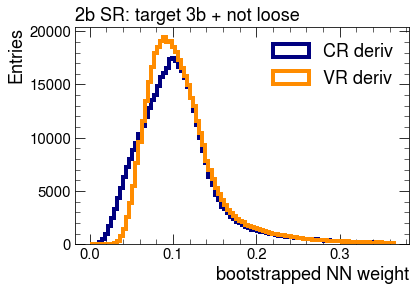

In [15]:
r = (0, np.percentile(sr.loc[sr.ntag==2,'w_2b'],99))

plt.hist(sr.loc[sr.ntag==2,'w_2b'],100,r,color='navy',histtype='step',lw=4,label='CR deriv')
plt.hist(sr.loc[sr.ntag==2,'w_2b_VR'],100,r,color='darkorange',histtype='step',lw=4,label='VR deriv')
plt.xlabel('bootstrapped NN weight',fontsize=18,loc='right')
plt.ylabel('Entries',fontsize=18,loc='top')
plt.legend(fontsize=18)
plt.title(f'2b SR: target 3b + not loose',loc='left')


plt.show()

**Make a plotting function**

I think for starters I'd like to compare
- 3b + not loose data
- CR deriv
- VR deriv 

all on the same plot

NameError: name 'yr' is not defined

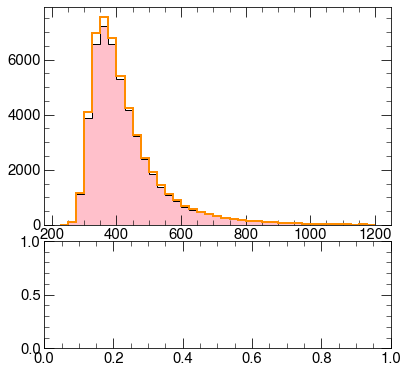

In [16]:
#evalRw(cr, 'm_hh', 39, [225,1200],bCat,'CR')
evalRw(sr, 'm_hh', 39, [225,1200],bCat,'SR')

In [ ]:
# n_2b,n_4b = evalRw(cr, 'm_hh', 39, [225,1200],bCat,'CR, $X_{wt}$ > 1.5',mi=cr.X_wt_tag>1.5)
# print(np.sum(n_2b) / np.sum(n_4b))

evalRw(sr[sr.X_wt_tag > 1.5], 'm_hh', 39, [225,1200],bCat,'SR, $X_{wt}$ > 1.5')

**Question:** What's the "natural split" for these?

In [ ]:
normedHist(sr, 'HT', 60, [160,960],bCat,'SR')

In [ ]:
normedHist(sr, 'm_hh', 39, [225,1200],bCat,'SR')

Does this change whether we are pre or post $X_{wt}$?

In [ ]:
normedHist(sr[sr.X_wt_tag > 1.5], 'HT', 60, [160,960],bCat,'SR $X_{wt}>1.5$')

**Next:** Let's workshop the code to make an *unrolled* categories histograms.

1. Just $\Delta \eta_{hh}$
2. Both $\Delta \eta_{hh}$ *and* $X_{wt}$

In [18]:
from matplotlib.ticker import MultipleLocator

In [19]:
from matplotlib.ticker import FixedLocator, LogLocator, AutoLocator

In [20]:
df = sr
col='m_hh'
color='pink'

In [21]:
Xhh_edgs = [0,.95,1.6]
eta_edgs = [0, .75, 1.5]
log=True

In [22]:
text = "$\mathbf{ATLAS}$ Data"+f" 20{yr} Internal\n"
text += "min_dR, NR bkts, SR (124,117)"

0 [ 225 1200]
1 [1200 2175]
2 [2175 3150]
3 [3150 4125]


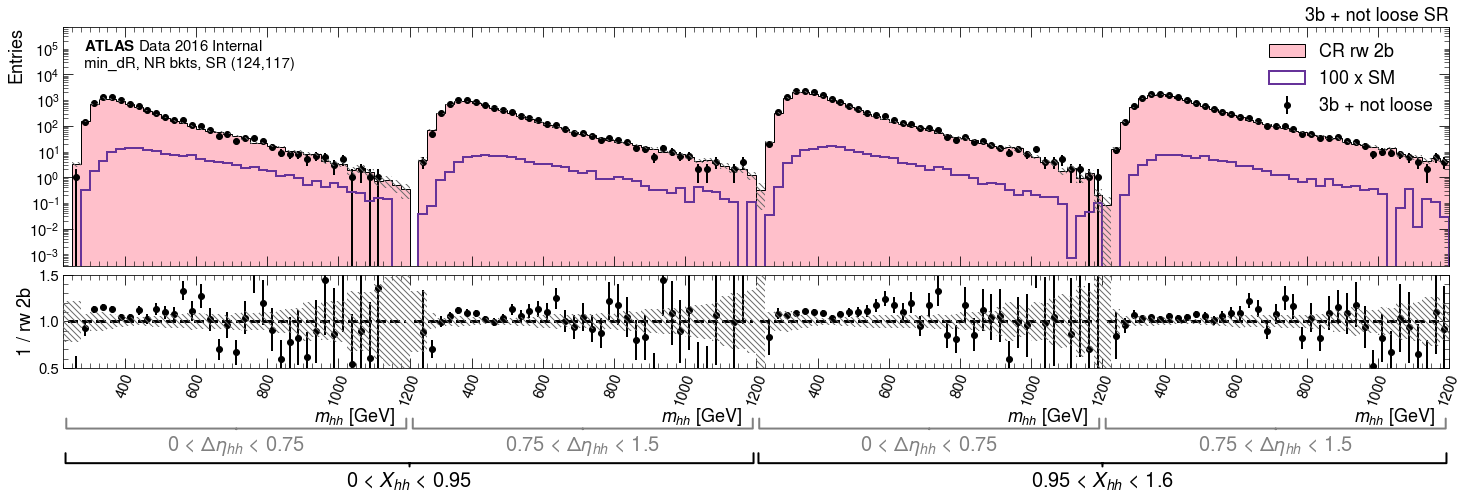

In [26]:
nb = len(eta_edgs)-1
nx = len(Xhh_edgs) - 1

fig, [ax1,ax2] = plt.subplots(2,1,figsize=(6*nb*nx, 6), sharex=True,
                              gridspec_kw={"height_ratios": [.72, .28], 
                                           "hspace":0.05, "left":0.098, "bottom":0.09})

l = bCat_to_label[bCat]

n = 39
r = np.array([225,1200])
dr = r[1]-r[0]

for i, xmin,xmax in zip(range(nx),Xhh_edgs[:-1], Xhh_edgs[1:]):

    mi = (df.Xhh > xmin) & (df.Xhh < xmax) 
    

    for j, eta_min, eta_max in zip(range(nb),eta_edgs[:-1],eta_edgs[1:]):

        
        k = i*nb+j
        
        
        mj = (df.X_wt_tag > 1.5) & mi & (df.dEta_hh > eta_min) & (df.dEta_hh < eta_max)

        m_2b = df[f'rw_to_{bCat}'] & mj
        m_4b = getBTagMask(df,bCat) & mj


        rk = r + k*dr
        print(k,rk)
        n_2b,ei,_ = ax1.hist(df.loc[m_2b,col] + (k*dr),n,rk, histtype='stepfilled',
                            fc=color,ec='k',label='CR rw 2b' if k==0 else None,
                            weights=df.loc[m_2b,'w_2b'],log=log)
        if k == 0:
            e = ei

        n_VR = np.histogram(df.loc[m_2b,col] + (k*dr),n,rk,
                            weights=df.loc[m_2b,'w_2b_VR'])[0]

        xx = 0.5 * (ei[1:] + ei[:-1])

        bs = calc_bstrap(df[m_2b], col, yr, norm, norm_IQR,e)
        w_2b = np.sqrt(np.histogram(df.loc[m_2b,col].values, e, weights=df.loc[m_2b,'w_2b'].values**2)[0])

        err = np.sqrt( (n_2b-n_VR)**2 + bs**2 + w_2b**2)

        ax1.fill_between(ei,[0]+list(n_2b-err),[0]+list(n_2b+err), 
                         step='pre',facecolor='None',edgecolor='dimgrey', 
                         hatch='\\\\\\\\', linewidth=0,zorder=5) 

        n_4b = np.histogram(df.loc[m_4b,col] + (k*dr),n,rk)[0]

        ax1.errorbar(xx,n_4b,np.sqrt(n_4b),label=l if k==0 else None,
                     color='k',marker='o',lw=0,elinewidth=2)

        scale=100
        if sdf is not None:

            smask = getBTagMask(sdf,bCat) & (sdf.dEta_hh > eta_min) & (sdf.dEta_hh < eta_max)
            smask = smask & (sdf.Xhh > xmin) & (sdf.Xhh < xmax)
            
            s = np.histogram(sdf.loc[smask,col],n,r,weights=sdf.loc[smask,'mc_sf'])[0]
            
#             s_err = np.sqrt(np.histogram(sdf[col],n,r,weights=sdf['mc_sf']**2)[0])
            
#             s_up = scale*np.array([0]+list(s+s_err))
#             s_dn = scale * np.array([0]+list(s-s_err))
            
            
#             ax1.fill_between(ei,s_up,s_dn, 
#                              step='pre',facecolor='None',edgecolor='rebeccapurple', 
#                              hatch='\\\\\\\\', linewidth=0,zorder=5) 
            
            ax1.hist(xx,ei,histtype='step',color='rebeccapurple',
                     lw=2,label=f'{scale} x SM' if k == 0 else None,
                     weights=scale*s)

        ax2.plot(xx,np.ones_like(xx),'k--')

        dn = [0] + list(1 - err[n_2b!=0]/n_2b[n_2b!=0])
        up = [0] + list(1 + err[n_2b!=0]/n_2b[n_2b!=0])

        ax2.fill_between([ei[0]] + list(ei[1:][n_2b!=0]),dn,up,
                         step='pre',facecolor='None',
                         edgecolor='dimgrey', hatch='\\\\\\\\', 
                         linewidth=0,zorder=5)
        ax2.errorbar(xx[n_2b!=0],n_4b[n_2b!=0]/n_2b[n_2b!=0],
                     np.sqrt(n_4b[n_2b!=0])/n_2b[n_2b!=0],label='4b',
                     color='k',marker='o',lw=0,elinewidth=2)

ax2.set_xlim(r[0],rk[1])
ax2.set_ylim(0.5,1.5)
    
start,stop = np.log10(ax1.get_ylim())
ax1.yaxis.set_minor_locator(LogLocator(base=10,subs=[1.,2.,3.,4.,5.,6.,7.,8.,9.],
                                       numticks=20))
ax1.set_ylim(np.power(10,start),np.power(10, stop + 0.3*(stop-start)))
    
ax2.xaxis.set_minor_locator(MultipleLocator(25))

ml = np.array([400,600,800,1000,1200])
mls = []
for k in range(nb*nx):
    mls += list(ml+k*dr)
    
ax2.xaxis.set_major_locator(FixedLocator(mls))

xticklocs = ax2.xaxis.get_majorticklocs()

xlabels = [f'{xtl:.0f}' for xtl in ml]*nb*nx
ax2.set_xticklabels(xlabels,rotation=70)

'''
Annotate the axes
'''
for i, xmin,xmax in zip(range(nx),Xhh_edgs[:-1],Xhh_edgs[1:]):
    
    
    for j,xl,eta_min, eta_max in zip(range(nb),np.arange(1,nx*nb+1)/(nx*nb),
                                     eta_edgs[:-1],eta_edgs[1:]):

        k = i * nx + j
        
        xl = (k + 1) / (nx*nb)
        
        rk = r + (k*dr)

        tj = f'{eta_min}' + ' < $\Delta \eta_{hh}$ < ' + f'{eta_max}'
        r_avg = rk.mean()

        ax2.text(xl-.01,-0.4,'$m_{hh}$ [GeV]',fontsize=18,transform=ax2.transAxes,ha='right',va='top')

        ax2.annotate(tj, xy=(r_avg, -0.65), xytext=(r_avg, -0.7), 
                     xycoords=('data','axes fraction'), 
                     fontsize=20, ha='center', va='top',color='grey',
                     arrowprops=dict(arrowstyle='-[, widthB=8.5, lengthB=0.5',
                                     color='grey', lw=2.0))
        
    ti = f'{xmin}' + ' < $X_{hh}$ < ' + f'{xmax}'
    
    ax2.annotate(ti, xy=(r[0] + dr*k, -1), xytext=(r[0] + dr*k, -1.1), 
             xycoords=('data','axes fraction'), 
             fontsize=20, ha='center', va='top',
             arrowprops=dict(arrowstyle='-[, widthB=17.2, lengthB=0.5', lw=2.0))

    
ax1.legend(loc='upper right',fontsize=18)
ax1.set_ylabel('Entries',fontsize=18,loc='top')
ax2.set_ylabel('1 / rw 2b',fontsize=18)
ax1.set_title('3b + not loose SR',loc='right')

fig.text(0.015,.95,text,ha='left',va='top',transform=ax1.transAxes,fontsize=15)

plt.show()

**Next:** Make the *same* plot, but demonstrating the *relative uncertainty* in each bin :)

0 [ 225 1200]
1 [1200 2175]
2 [2175 3150]


<ipython-input-259-b80e94e04a77>:48: RuntimeWarning: invalid value encountered in true_divide
  label='total error' if k==0 else None, weights=(err/n_2b)[n_2b!=0])
<ipython-input-259-b80e94e04a77>:51: RuntimeWarning: invalid value encountered in true_divide
  weights=(np.abs(n_2b-n_VR)/n_2b)[n_2b!=0],
<ipython-input-259-b80e94e04a77>:60: RuntimeWarning: invalid value encountered in true_divide
  plt.scatter(xx[n_2b!=0],(np.abs(n_4b-n_2b)/n_2b)[n_2b!=0],color='deeppink',


3 [3150 4125]


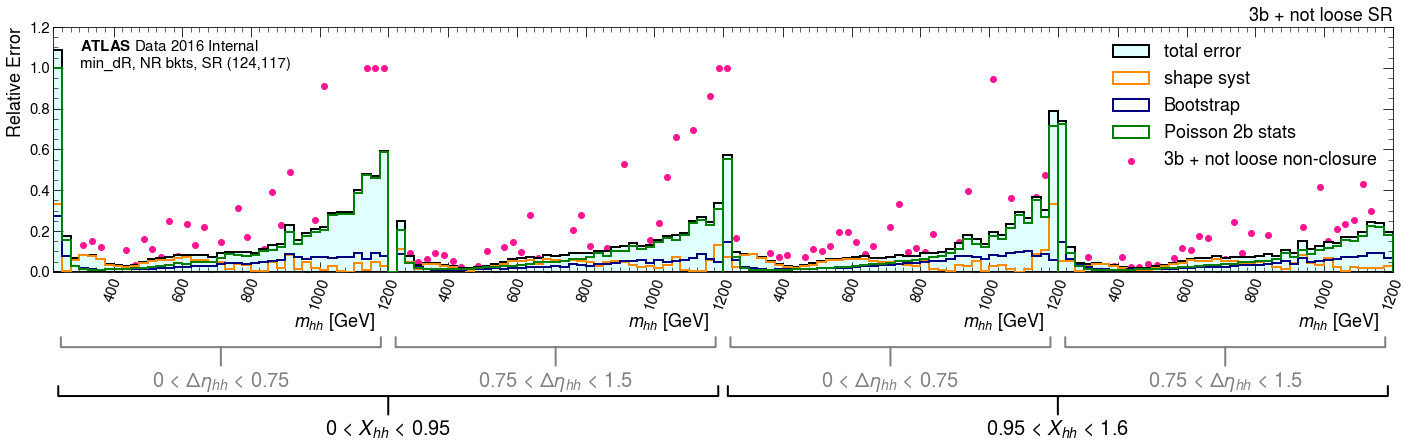

In [259]:

nb = len(eta_edgs)-1
nx = len(Xhh_edgs) - 1

plt.figure(figsize=(6*nb*nx, 4.5))

l = bCat_to_label[bCat]

n = 39
r = np.array([225,1200])
dr = r[1]-r[0]

lw=2

for i, xmin,xmax in zip(range(nx),Xhh_edgs[:-1], Xhh_edgs[1:]):

    mi = (df.Xhh > xmin) & (df.Xhh < xmax) 
    
    for j, eta_min, eta_max in zip(range(nb),eta_edgs[:-1],eta_edgs[1:]):
    
        k = i*nb+j    
        mj = mi & (df.dEta_hh > eta_min) & (df.dEta_hh < eta_max)

        m_2b = df[f'rw_to_{bCat}'] & mj
        m_4b = getBTagMask(df,bCat) & mj


        rk = r + k*dr
        print(k,rk)
        n_2b,ei,_ = ax1.hist(df.loc[m_2b,col] + (k*dr),n,rk, histtype='stepfilled',
                            fc=color,ec='k',label='CR rw 2b' if k==0 else None,
                            weights=df.loc[m_2b,'w_2b'],lw=lw)
        if k == 0:
            e = ei

        
        n_VR = np.histogram(df.loc[m_2b,col] + (k*dr),n,rk,
                            weights=df.loc[m_2b,'w_2b_VR'])[0]

        xx = 0.5 * (ei[1:] + ei[:-1])
        
        bs = calc_bstrap(df[m_2b], col, yr, norm, norm_IQR,e)
        w_2b = np.sqrt(np.histogram(df.loc[m_2b,col].values, e, weights=df.loc[m_2b,'w_2b'].values**2)[0])

        err = np.sqrt( (n_2b-n_VR)**2 + bs**2 + w_2b**2)


        plt.hist(xx[n_2b!=0], ei, histtype='stepfilled', fc='lightcyan',ec='k',lw=lw,
                 label='total error' if k==0 else None, weights=(err/n_2b)[n_2b!=0])
        
        plt.hist(xx[n_2b!=0], ei, histtype='step', color='darkorange',
                 weights=(np.abs(n_2b-n_VR)/n_2b)[n_2b!=0],
                 label='shape syst' if k==0 else None,lw=lw)
        plt.hist(xx[n_2b!=0], ei, histtype='step', color='navy',weights=bs[n_2b!=0]/n_2b[n_2b!=0],
                 label='Bootstrap' if k==0 else None,lw=lw)
        plt.hist(xx[n_2b!=0], ei, histtype='step', color='green',weights=w_2b[n_2b!=0]/n_2b[n_2b!=0],
                 label='Poisson 2b stats' if k==0 else None,lw=lw)
                
        n_4b = np.histogram(df.loc[m_4b,col] + (k*dr),n,rk)[0]

        plt.scatter(xx[n_2b!=0],(np.abs(n_4b-n_2b)/n_2b)[n_2b!=0],color='deeppink',
                    label=f'{l} non-closure' if k==0 else None)
        
ax = plt.gca()
      
plt.ylim(0,1.2)
plt.xlim(r[0],rk[1])    
ax.xaxis.set_minor_locator(MultipleLocator(25))

ml = np.array([400,600,800,1000,1200])
mls = []
for k in range(nb*nx):
    mls += list(ml+k*dr)
    
ax.xaxis.set_major_locator(FixedLocator(mls))

xticklocs = ax.xaxis.get_majorticklocs()

xlabels = [f'{xtl:.0f}' for xtl in ml]*nb*nx
ax.set_xticklabels(xlabels,rotation=70)

'''
Annotate the axes
'''
for i, xmin,xmax in zip(range(nx),Xhh_edgs[:-1],Xhh_edgs[1:]):
    
    
    for j,xl,eta_min, eta_max in zip(range(nb),np.arange(1,nx*nb+1)/(nx*nb),
                                     eta_edgs[:-1],eta_edgs[1:]):

        k = i * nx + j
        
        xl = (k + 1) / (nx*nb)
        
        rk = r + (k*dr)

        tj = f'{eta_min}' + ' < $\Delta \eta_{hh}$ < ' + f'{eta_max}'
        r_avg = rk.mean()

        ax.text(xl-.01,-0.25,'$m_{hh}$ [GeV]',fontsize=18,transform=ax.transAxes,ha='right',va='bottom')

        ax.annotate(tj, xy=(r_avg, -0.3), xytext=(r_avg, -0.4), 
                     xycoords=('data','axes fraction'), 
                     fontsize=20, ha='center', va='top',color='grey',
                     arrowprops=dict(arrowstyle='-[, widthB=8, lengthB=0.5',
                                     color='grey', lw=2.0))
        
    ti = f'{xmin}' + ' < $X_{hh}$ < ' + f'{xmax}'
    
    ax.annotate(ti, xy=(r[0] + dr*k, -.5), xytext=(r[0] + dr*k, -.6), 
             xycoords=('data','axes fraction'), 
             fontsize=20, ha='center', va='top',
             arrowprops=dict(arrowstyle='-[, widthB=16.5, lengthB=0.5', lw=2.0))

    
plt.legend(loc='upper right',fontsize=18)
plt.ylabel('Relative Error',fontsize=18,loc='top')
plt.title('3b + not loose SR',loc='right')

plt.text(0.02,.95,text,ha='left',va='top',transform=ax.transAxes,fontsize=15)

plt.show()

## And now post-$X_{wt}$